In [1]:
%matplotlib inline
import torch
from torch.utils.data import DataLoader, Subset, default_collate
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.transforms import v2
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import timm
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

import time
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define transformations

In [2]:
batch_size = 512
cutmix = v2.CutMix(num_classes=100)
mixup = v2.MixUp(num_classes=100)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])
def collate_fn_cutmix(batch):
    return cutmix(*default_collate(batch))
def collate_fn_mixup(batch):
    return mixup(*default_collate(batch))
def collate_fn_or(batch):
    return cutmix_or_mixup(*default_collate(batch))


def prepare_datasets(train_transform, test_transform, cutmix_or_mixup, batch_size=batch_size, val_ratio=0.1, random_seed=42):
    # Ensure the same for each split
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    full_trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
    testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)

    train_indices, val_indices = train_test_split(
        list(range(len(full_trainset))),
        test_size=val_ratio,
        stratify=full_trainset.targets,
        random_state=random_seed
    )
    
    # print(f'Validation indices (first 10): {val_indices[:10]}')  # for verifying splits

    # Split train set and validation set
    trainset = Subset(full_trainset, train_indices)
    valset = Subset(full_trainset, val_indices)
    
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

    if cutmix_or_mixup == 0:
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
        valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)
    elif cutmix_or_mixup == 1:
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn_cutmix)
        valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn_cutmix)
    elif cutmix_or_mixup == 2:
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn_mixup)
        valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn_mixup)
    else:
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn_or)
        valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn_or)


    return trainloader, valloader, testloader


# Define transformations
test_transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),  # to float32 in [0, 1]
    v2.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
])

train_transform_basic = v2.Compose([
    v2.PILToTensor(),
    v2.RandomResizedCrop(size=(32, 32), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),  # to float32 in [0, 1]
    v2.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
])

train_transform_randaug = v2.Compose([
    v2.PILToTensor(),
    v2.RandomResizedCrop(size=(32, 32), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandAugment(num_ops=2, magnitude=10),
    v2.ToDtype(torch.float32, scale=True),  # to float32 in [0, 1]
    v2.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
])


trainloader_basic, valloader_basic, testloader_basic = prepare_datasets(train_transform_basic, test_transform, 0)
# trainloader_randaug, valloader_randaug, testloader_randaug = prepare_datasets(train_transform_randaug, test_transform, 0)
trainloader_cutmix, valloader_cutmix, testloader_cutmix = prepare_datasets(train_transform_basic, test_transform, 1)
# trainloader_mixup, valloader_mixup, testloader_mixup = prepare_datasets(train_transform_basic, test_transform, 2)
# trainloader_all, valloader_all, testloader_all = prepare_datasets(train_transform_randaug, test_transform, 3)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Model training function

In [3]:
def train_model(model, trainloader, valloader, optimizer, num_epochs, scheduler=None, warmup_epochs=5, log_dir='./logs'):
    writer = SummaryWriter(log_dir=log_dir)
    criterion = nn.CrossEntropyLoss()
    
    model = model.to(device)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    pbar_epochs = tqdm(total=num_epochs, desc='Overall Progress', position=0)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        if epoch < warmup_epochs:
            lr_scale = min(1., float(epoch + 1) / warmup_epochs)
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * pg['initial_lr']
        
        pbar_batches = tqdm(total=len(trainloader), desc=f'Epoch {epoch+1}/{num_epochs}', position=1, leave=False)
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            pbar_batches.set_postfix(loss=loss.item())
            pbar_batches.update()

        pbar_batches.close()
        epoch_train_loss = running_loss / len(trainloader.dataset)
        epoch_train_acc = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Write to TensorBoard
        writer.add_scalar('train_loss', epoch_train_loss, epoch)
        writer.add_scalar('train_accuracy', epoch_train_acc, epoch)
        
        if scheduler is not None:
            scheduler.step()
        
        # Validation loop
        model.eval()
        correct_val = 0
        total_val = 0
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        epoch_val_loss = running_val_loss / len(valloader.dataset)
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Write to TensorBoard
        writer.add_scalar('validation_loss', epoch_val_loss, epoch)
        writer.add_scalar('validation_accuracy', epoch_val_acc, epoch)

        pbar_epochs.set_postfix(
                train_loss=f"{epoch_train_loss:.4f}", 
                train_acc=f"{100*epoch_train_acc:.2f}%", 
                val_loss=f"{epoch_val_loss:.4f}", 
                val_acc=f"{100*epoch_val_acc:.2f}%"
            )
        pbar_epochs.update()

    pbar_epochs.close()
    writer.close()
    print('Training complete!')
    print(f'Training Accuracy: {train_accuracies[-1]:.4f}, Best Validation Accuracy: {max(val_accuracies):.4f}')
    return train_losses, train_accuracies, val_losses, val_accuracies


In [4]:
def plot_curves(train_losses, train_accuracies, val_losses, val_accuracies, item_names):

    num_functions = len(item_names)
    
    # Plotting results
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 10))
    
    # Plot training loss
    plt.subplot(2, 2, 1)
    for i in range(num_functions):
        plt.plot(train_losses[i], label=f'{item_names[i]}', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(2, 2, 2)
    for i in range(num_functions):
        plt.plot(train_accuracies[i], label=f'{item_names[i]}', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    # Plot test loss
    plt.subplot(2, 2, 3)
    for i in range(num_functions):
        plt.plot(val_losses[i], label=f'{item_names[i]}', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()

    # Plot test accuracy
    plt.subplot(2, 2, 4)
    for i in range(num_functions):
        plt.plot(val_accuracies[i], label=f'{item_names[i]}', linewidth=1.5)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
def plot_curves_two(train_losses1, train_accuracies1, val_losses1, val_accuracies1, 
                train_losses2, train_accuracies2, val_losses2, val_accuracies2, item_names):
    
    num_functions = len(item_names)
    
    # Plotting results
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 10))
    
    # Plot training loss
    plt.subplot(2, 2, 1)
    for i in range(num_functions):
        plt.plot(train_losses1[i], label=f'EfficientNetB0 - {item_names[i]}', linestyle='-', linewidth=2.0)
        plt.plot(train_losses2[i], label=f'MobileViT_S - {item_names[i]}', linestyle='--', linewidth=2.0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(2, 2, 2)
    for i in range(num_functions):
        plt.plot(train_accuracies1[i], label=f'EfficientNetB0 - {item_names[i]}', linestyle='-', linewidth=2.0)
        plt.plot(train_accuracies2[i], label=f'MobileViT_S - {item_names[i]}', linestyle='--', linewidth=2.0)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    # Plot test loss
    plt.subplot(2, 2, 3)
    for i in range(num_functions):
        plt.plot(val_losses1[i], label=f'EfficientNetB0 - {item_names[i]}', linestyle='-', linewidth=2.0)
        plt.plot(val_losses2[i], label=f'MobileViT_S - {item_names[i]}', linestyle='--', linewidth=2.0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()

    # Plot test accuracy
    plt.subplot(2, 2, 4)
    for i in range(num_functions):
        plt.plot(val_accuracies1[i], label=f'EfficientNetB0 - {item_names[i]}', linestyle='-', linewidth=2.0)
        plt.plot(val_accuracies2[i], label=f'MobileViT_S - {item_names[i]}', linestyle='--', linewidth=2.0)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Model definition

In [6]:
# EfficientNet-B0
class EfficientNetB0_CIFAR100(torch.nn.Module):
    def __init__(self):
        super(EfficientNetB0_CIFAR100, self).__init__()
        self.model = models.efficientnet_b0(weights=None)
        self.model.features[0][0] = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 100)

    def forward(self, x):
        return self.model(x)

# MobileViT-S
class MobileViT_S_CIFAR100(torch.nn.Module):
    def __init__(self):
        super(MobileViT_S_CIFAR100, self).__init__()
        self.model = timm.create_model('mobilevit_s', pretrained=False, num_classes=100)
        self.model.stem.conv = nn.Conv2d(3, self.model.stem.conv.out_channels, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        return self.model(x)

## Try learning rates

 ======> Training EfficientNetB0_CIFAR100: Adam-512_lr=0.02_weightdecay=1e-05


Overall Progress: 100%|██████████| 20/20 [03:39<00:00, 10.99s/it, train_acc=24.43%, train_loss=2.9945, val_acc=24.02%, val_loss=3.0268]


Training complete!
Training Accuracy: 0.2443, Best Validation Accuracy: 0.2402
 ======> Training EfficientNetB0_CIFAR100: Adam-512_lr=0.002_weightdecay=1e-05


Overall Progress: 100%|██████████| 20/20 [03:40<00:00, 11.01s/it, train_acc=40.40%, train_loss=2.2587, val_acc=37.40%, val_loss=2.4569]


Training complete!
Training Accuracy: 0.4040, Best Validation Accuracy: 0.3740
 ======> Training EfficientNetB0_CIFAR100: Adam-512_lr=0.0002_weightdecay=1e-05


Overall Progress: 100%|██████████| 20/20 [03:41<00:00, 11.08s/it, train_acc=21.45%, train_loss=3.2326, val_acc=21.50%, val_loss=3.2227]


Training complete!
Training Accuracy: 0.2145, Best Validation Accuracy: 0.2150
 ======> Training MobileViT_S_CIFAR100: Adam-512_lr0.02_weightdecay-1e-05


Overall Progress:   0%|          | 0/20 [00:00<?, ?it/s]/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Overall Progress: 100%|██████████| 20/20 [04:45<00:00, 14.30s/it, train_acc=24.13%, train_loss=3.0732, val_acc=23.08%, val_loss=3.1561]


Training complete!
Training Accuracy: 0.2413, Best Validation Accuracy: 0.2308
 ======> Training MobileViT_S_CIFAR100: Adam-512_lr0.002_weightdecay-1e-05


Overall Progress: 100%|██████████| 20/20 [04:45<00:00, 14.28s/it, train_acc=47.32%, train_loss=1.9702, val_acc=41.90%, val_loss=2.2422]


Training complete!
Training Accuracy: 0.4732, Best Validation Accuracy: 0.4210
 ======> Training MobileViT_S_CIFAR100: Adam-512_lr0.0002_weightdecay-1e-05


Overall Progress: 100%|██████████| 20/20 [04:46<00:00, 14.30s/it, train_acc=31.74%, train_loss=2.6929, val_acc=29.52%, val_loss=2.8199]


Training complete!
Training Accuracy: 0.3174, Best Validation Accuracy: 0.2980


Overall Progress:  50%|█████     | 10/20 [31:30<31:30, 189.02s/it, train_acc=1.10%, train_loss=12.9898, val_acc=1.00%, val_loss=23.8817]


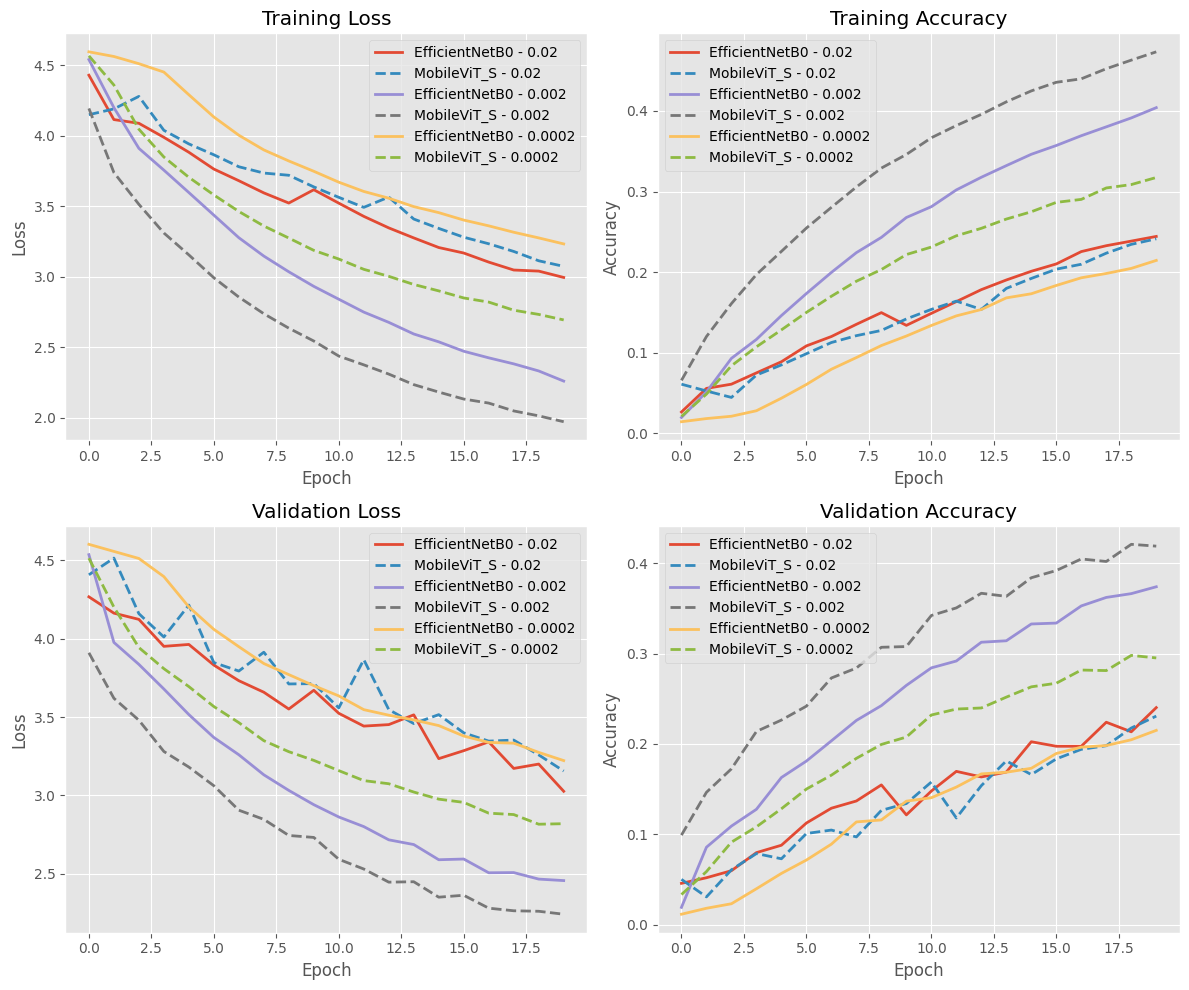

In [9]:
# Training parameters
num_epochs = 20
lr_list = [0.02, 0.002, 0.0002]
weight_decay_list = [1e-5]
optimizers = [
    # 'SGD',
    'Adam',
]

all_train_losses_model1 = []
all_train_accuracies_model1 = []
all_val_losses_model1 = []
all_val_accuracies_model1 = []

all_train_losses_model2 = []
all_train_accuracies_model2 = []
all_val_losses_model2 = []
all_val_accuracies_model2 = []

for base_lr in lr_list:
    for weight_decay in weight_decay_list:
        for opt in optimizers:
            # Training for Model 1
            mdl1 = EfficientNetB0_CIFAR100()
            mdl1 = mdl1.to(device)
            model_name1 = mdl1.__class__.__name__
            print(f" ======> Training {model_name1}: {opt}-{batch_size}_lr={base_lr}_weightdecay={weight_decay}")
            # optimizer1 = optim.SGD(mdl1.parameters(), lr=base_lr, weight_decay=weight_decay)
            optimizer1 = optim.Adam(mdl1.parameters(), lr=base_lr, weight_decay=weight_decay)
            scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=200, gamma=0.97)
            log_dir1 = f'./logs/{model_name1}/{opt}-{batch_size}_lr{base_lr}_wd-{weight_decay}_e{num_epochs}'
            train_losses1, train_accuracies1, val_losses1, val_accuracies1 = train_model(mdl1, trainloader_basic, valloader_basic, optimizer1, num_epochs, scheduler=scheduler1, log_dir=log_dir1)
            all_train_losses_model1.append(train_losses1)
            all_train_accuracies_model1.append(train_accuracies1)
            all_val_losses_model1.append(val_losses1)
            all_val_accuracies_model1.append(val_accuracies1)

for base_lr in lr_list:
    for weight_decay in weight_decay_list:
        for opt in optimizers:
            # Training for Model 2
            mdl2 = MobileViT_S_CIFAR100()
            mdl2 = mdl2.to(device)
            model_name2 = mdl2.__class__.__name__
            print(f" ======> Training {model_name2}: {opt}-{batch_size}_lr{base_lr}_weightdecay-{weight_decay}")
            # optimizer2 = optim.SGD(mdl2.parameters(), lr=base_lr, weight_decay=weight_decay)
            optimizer2 = optim.Adam(mdl2.parameters(), lr=base_lr, weight_decay=weight_decay)
            scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=200, gamma=0.97)
            log_dir2 = f'./logs/{model_name2}/{opt}-{batch_size}_lr{base_lr}_wd-{weight_decay}_e{num_epochs}'
            train_losses2, train_accuracies2, val_losses2, val_accuracies2 = train_model(mdl2, trainloader_basic, valloader_basic, optimizer2, num_epochs, scheduler=scheduler2, log_dir=log_dir2)
            all_train_losses_model2.append(train_losses2)
            all_train_accuracies_model2.append(train_accuracies2)
            all_val_losses_model2.append(val_losses2)
            all_val_accuracies_model2.append(val_accuracies2)

plot_curves_two(all_train_losses_model1, all_train_accuracies_model1, all_val_losses_model1, all_val_accuracies_model1, 
            all_train_losses_model2, all_train_accuracies_model2, all_val_losses_model2, all_val_accuracies_model2, lr_list)

 ======> Training EfficientNetB0_CIFAR100: Adam-512_lr=0.1_weightdecay=1e-05


Overall Progress: 100%|██████████| 20/20 [03:42<00:00, 11.13s/it, train_acc=3.03%, train_loss=4.4520, val_acc=1.38%, val_loss=5.6958]       


Training complete!
Training Accuracy: 0.0303, Best Validation Accuracy: 0.0344


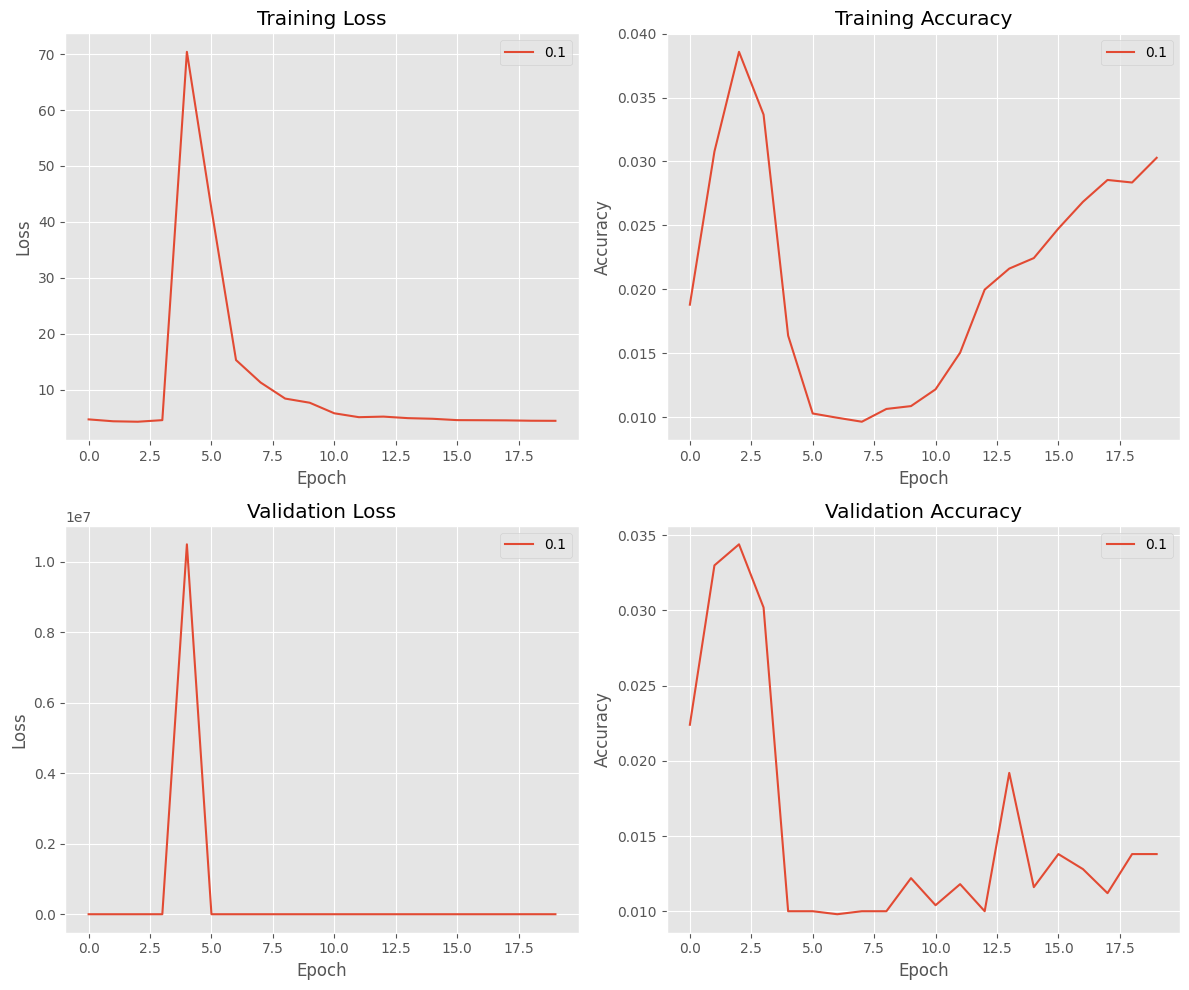

In [10]:
num_epochs = 20
lr_list = [0.1]
weight_decay_list = [1e-5]
optimizers = [
    # 'SGD',
    'Adam',
]
all_train_losses_model1 = []
all_train_accuracies_model1 = []
all_val_losses_model1 = []
all_val_accuracies_model1 = []

for base_lr in lr_list:
    for weight_decay in weight_decay_list:
        for opt in optimizers:
            mdl1 = EfficientNetB0_CIFAR100()
            mdl1 = mdl1.to(device)
            model_name1 = mdl1.__class__.__name__
            print(f" ======> Training {model_name1}: {opt}-{batch_size}_lr={base_lr}_weightdecay={weight_decay}")
            # optimizer1 = optim.SGD(mdl1.parameters(), lr=base_lr, weight_decay=weight_decay)
            optimizer1 = optim.Adam(mdl1.parameters(), lr=base_lr, weight_decay=weight_decay)
            scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=200, gamma=0.97)
            log_dir1 = f'./logs/{model_name1}/{opt}-{batch_size}_lr{base_lr}_wd-{weight_decay}_e{num_epochs}'
            train_losses1, train_accuracies1, val_losses1, val_accuracies1 = train_model(mdl1, trainloader_basic, valloader_basic, optimizer1, num_epochs, scheduler=scheduler1, log_dir=log_dir1)
            all_train_losses_model1.append(train_losses1)
            all_train_accuracies_model1.append(train_accuracies1)
            all_val_losses_model1.append(val_losses1)
            all_val_accuracies_model1.append(val_accuracies1)

plot_curves(all_train_losses_model1, all_train_accuracies_model1, all_val_losses_model1, all_val_accuracies_model1, lr_list)

 ======> Training MobileViT_S_CIFAR100: Adam-512_lr0.1_weightdecay-1e-05


Overall Progress:   0%|          | 0/20 [00:00<?, ?it/s]/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Overall Progress: 100%|██████████| 20/20 [04:46<00:00, 14.34s/it, train_acc=13.20%, train_loss=3.6591, val_acc=7.92%, val_loss=4.0884] 


Training complete!
Training Accuracy: 0.1320, Best Validation Accuracy: 0.1080


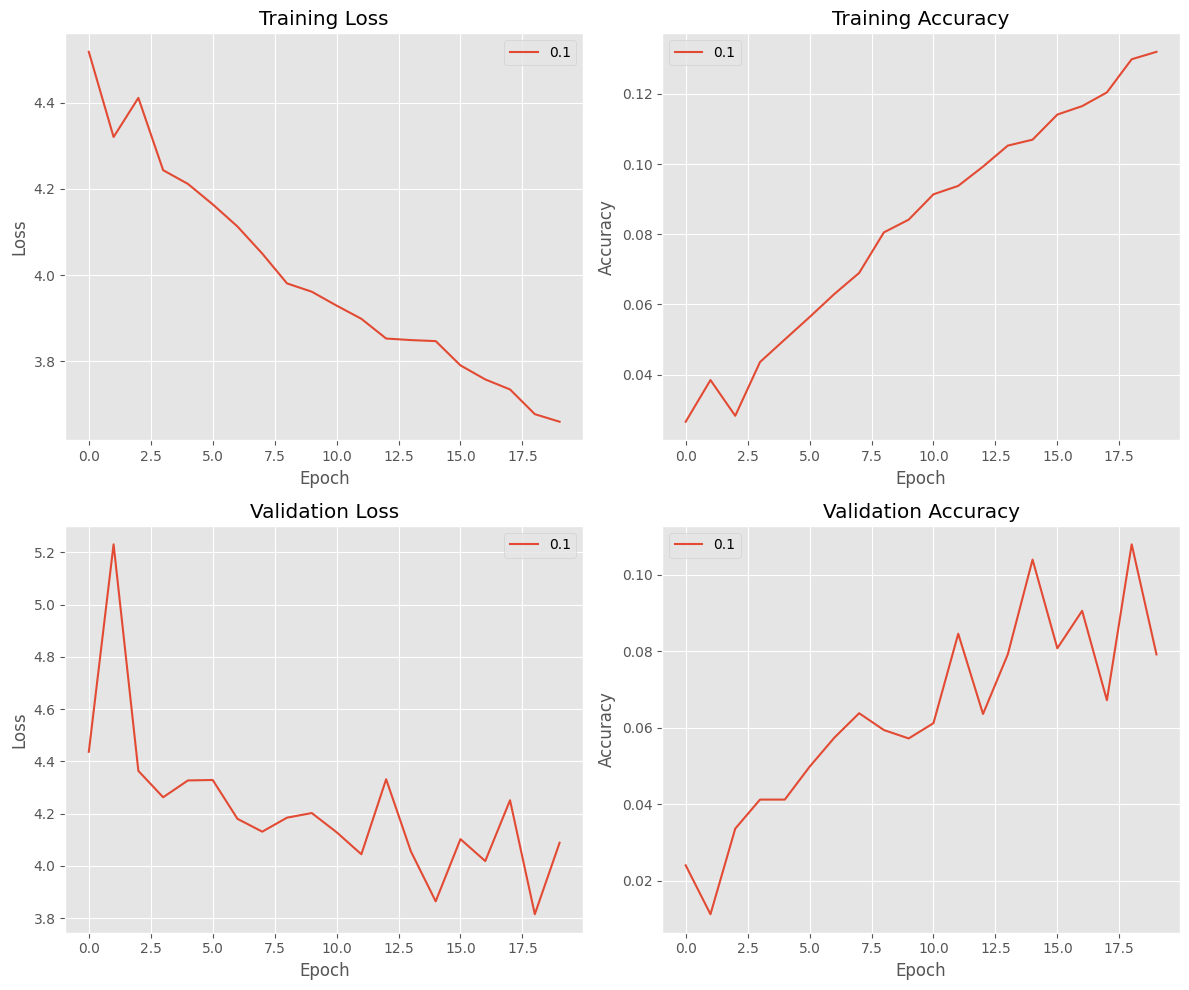

In [11]:
num_epochs = 20
lr_list = [0.1]
weight_decay_list = [1e-5]
optimizers = [
    # 'SGD',
    'Adam',
]

all_train_losses_model2 = []
all_train_accuracies_model2 = []
all_val_losses_model2 = []
all_val_accuracies_model2 = []

for base_lr in lr_list:
    for weight_decay in weight_decay_list:
        for opt in optimizers:
            mdl2 = MobileViT_S_CIFAR100()
            mdl2 = mdl2.to(device)
            model_name2 = mdl2.__class__.__name__
            print(f" ======> Training {model_name2}: {opt}-{batch_size}_lr{base_lr}_weightdecay-{weight_decay}")
            # optimizer2 = optim.SGD(mdl2.parameters(), lr=base_lr, weight_decay=weight_decay)
            optimizer2 = optim.Adam(mdl2.parameters(), lr=base_lr, weight_decay=weight_decay)
            scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=200, gamma=0.97)
            log_dir2 = f'./logs/{model_name2}/{opt}-{batch_size}_lr{base_lr}_wd-{weight_decay}_e{num_epochs}'
            train_losses2, train_accuracies2, val_losses2, val_accuracies2 = train_model(mdl2, trainloader_basic, valloader_basic, optimizer2, num_epochs, scheduler=scheduler2, log_dir=log_dir2)
            all_train_losses_model2.append(train_losses2)
            all_train_accuracies_model2.append(train_accuracies2)
            all_val_losses_model2.append(val_losses2)
            all_val_accuracies_model2.append(val_accuracies2)

plot_curves(all_train_losses_model2, all_train_accuracies_model2, all_val_losses_model2, all_val_accuracies_model2, lr_list)

## Try weight decay

 ======> Training EfficientNetB0_CIFAR100: Adam-512_lr=0.002_weightdecay=0.01


Overall Progress: 100%|██████████| 20/20 [03:43<00:00, 11.15s/it, train_acc=11.89%, train_loss=3.7592, val_acc=10.34%, val_loss=3.9049]


Training complete!
Training Accuracy: 0.1189, Best Validation Accuracy: 0.1118
 ======> Training EfficientNetB0_CIFAR100: Adam-512_lr=0.002_weightdecay=0.001


Overall Progress: 100%|██████████| 20/20 [03:44<00:00, 11.21s/it, train_acc=30.03%, train_loss=2.7326, val_acc=28.68%, val_loss=2.8031]


Training complete!
Training Accuracy: 0.3003, Best Validation Accuracy: 0.2868
 ======> Training EfficientNetB0_CIFAR100: Adam-512_lr=0.002_weightdecay=0.0001


Overall Progress: 100%|██████████| 20/20 [03:43<00:00, 11.16s/it, train_acc=38.01%, train_loss=2.3656, val_acc=36.44%, val_loss=2.4631]


Training complete!
Training Accuracy: 0.3801, Best Validation Accuracy: 0.3644
 ======> Training EfficientNetB0_CIFAR100: Adam-512_lr=0.002_weightdecay=1e-05


Overall Progress: 100%|██████████| 20/20 [03:42<00:00, 11.15s/it, train_acc=40.50%, train_loss=2.2636, val_acc=37.32%, val_loss=2.4428]


Training complete!
Training Accuracy: 0.4050, Best Validation Accuracy: 0.3732
 ======> Training MobileViT_S_CIFAR100: Adam-512_lr0.002_weightdecay-0.01


Overall Progress: 100%|██████████| 20/20 [04:46<00:00, 14.34s/it, train_acc=13.79%, train_loss=3.6785, val_acc=10.06%, val_loss=3.8352]


Training complete!
Training Accuracy: 0.1379, Best Validation Accuracy: 0.1130
 ======> Training MobileViT_S_CIFAR100: Adam-512_lr0.002_weightdecay-0.001


Overall Progress: 100%|██████████| 20/20 [04:47<00:00, 14.36s/it, train_acc=31.74%, train_loss=2.6777, val_acc=28.78%, val_loss=2.8519]


Training complete!
Training Accuracy: 0.3174, Best Validation Accuracy: 0.2918
 ======> Training MobileViT_S_CIFAR100: Adam-512_lr0.002_weightdecay-0.0001


Overall Progress: 100%|██████████| 20/20 [04:52<00:00, 14.64s/it, train_acc=45.30%, train_loss=2.0438, val_acc=41.52%, val_loss=2.2594]


Training complete!
Training Accuracy: 0.4530, Best Validation Accuracy: 0.4152
 ======> Training MobileViT_S_CIFAR100: Adam-512_lr0.002_weightdecay-1e-05


Overall Progress: 100%|██████████| 20/20 [04:47<00:00, 14.38s/it, train_acc=46.53%, train_loss=1.9906, val_acc=42.70%, val_loss=2.1981]


Training complete!
Training Accuracy: 0.4653, Best Validation Accuracy: 0.4270


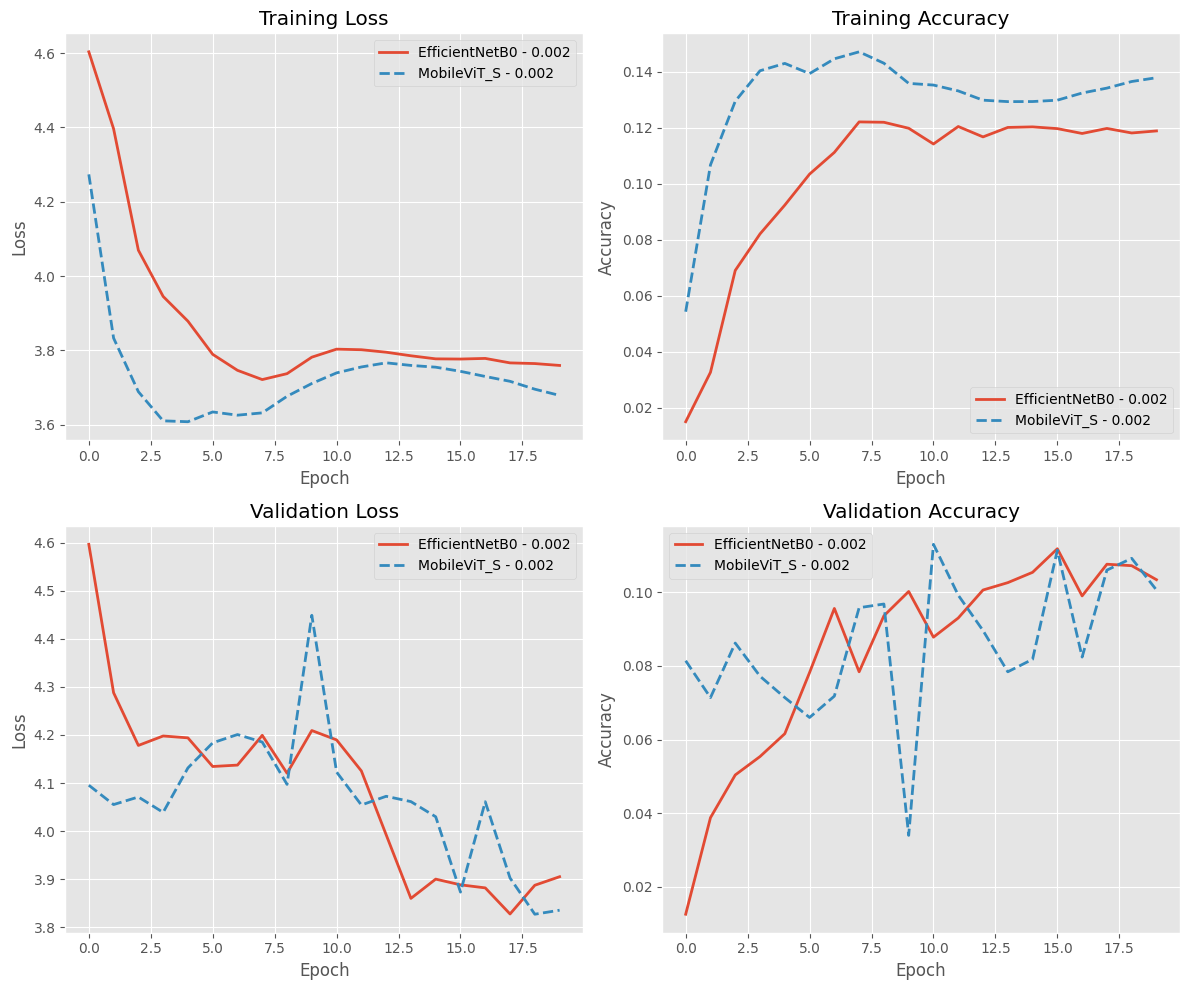

In [12]:
# Training parameters
num_epochs = 20
lr_list = [0.002]
weight_decay_list = [1e-2, 1e-3, 1e-4, 1e-5]
optimizers = [
    # 'SGD',
    'Adam',
]

all_train_losses_model1 = []
all_train_accuracies_model1 = []
all_val_losses_model1 = []
all_val_accuracies_model1 = []

all_train_losses_model2 = []
all_train_accuracies_model2 = []
all_val_losses_model2 = []
all_val_accuracies_model2 = []

for base_lr in lr_list:
    for weight_decay in weight_decay_list:
        for opt in optimizers:
            # Training for Model 1
            mdl1 = EfficientNetB0_CIFAR100()
            torch.cuda.empty_cache()
            model_name1 = mdl1.__class__.__name__
            print(f" ======> Training {model_name1}: {opt}-{batch_size}_lr={base_lr}_weightdecay={weight_decay}")
            # optimizer1 = optim.SGD(mdl1.parameters(), lr=base_lr, weight_decay=weight_decay)
            optimizer1 = optim.Adam(mdl1.parameters(), lr=base_lr, weight_decay=weight_decay)
            scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=200, gamma=0.97)
            log_dir1 = f'./logs/{model_name1}/{opt}-{batch_size}_lr{base_lr}_wd-{weight_decay}_e{num_epochs}'
            train_losses1, train_accuracies1, val_losses1, val_accuracies1 = train_model(mdl1, trainloader_basic, valloader_basic, optimizer1, num_epochs, scheduler=scheduler1, log_dir=log_dir1)
            all_train_losses_model1.append(train_losses1)
            all_train_accuracies_model1.append(train_accuracies1)
            all_val_losses_model1.append(val_losses1)
            all_val_accuracies_model1.append(val_accuracies1)

for base_lr in lr_list:
    for weight_decay in weight_decay_list:
        for opt in optimizers:
            # Training for Model 2
            mdl2 = MobileViT_S_CIFAR100()
            torch.cuda.empty_cache()
            model_name2 = mdl2.__class__.__name__
            print(f" ======> Training {model_name2}: {opt}-{batch_size}_lr{base_lr}_weightdecay-{weight_decay}")
            # optimizer2 = optim.SGD(mdl2.parameters(), lr=base_lr, weight_decay=weight_decay)
            optimizer2 = optim.Adam(mdl2.parameters(), lr=base_lr, weight_decay=weight_decay)
            scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=200, gamma=0.97)
            log_dir2 = f'./logs/{model_name2}/{opt}-{batch_size}_lr{base_lr}_wd-{weight_decay}_e{num_epochs}'
            train_losses2, train_accuracies2, val_losses2, val_accuracies2 = train_model(mdl2, trainloader_basic, valloader_basic, optimizer2, num_epochs, scheduler=scheduler2, log_dir=log_dir2)
            all_train_losses_model2.append(train_losses2)
            all_train_accuracies_model2.append(train_accuracies2)
            all_val_losses_model2.append(val_losses2)
            all_val_accuracies_model2.append(val_accuracies2)

plot_curves_two(all_train_losses_model1, all_train_accuracies_model1, all_val_losses_model1, all_val_accuracies_model1, 
            all_train_losses_model2, all_train_accuracies_model2, all_val_losses_model2, all_val_accuracies_model2, weight_decay_list)

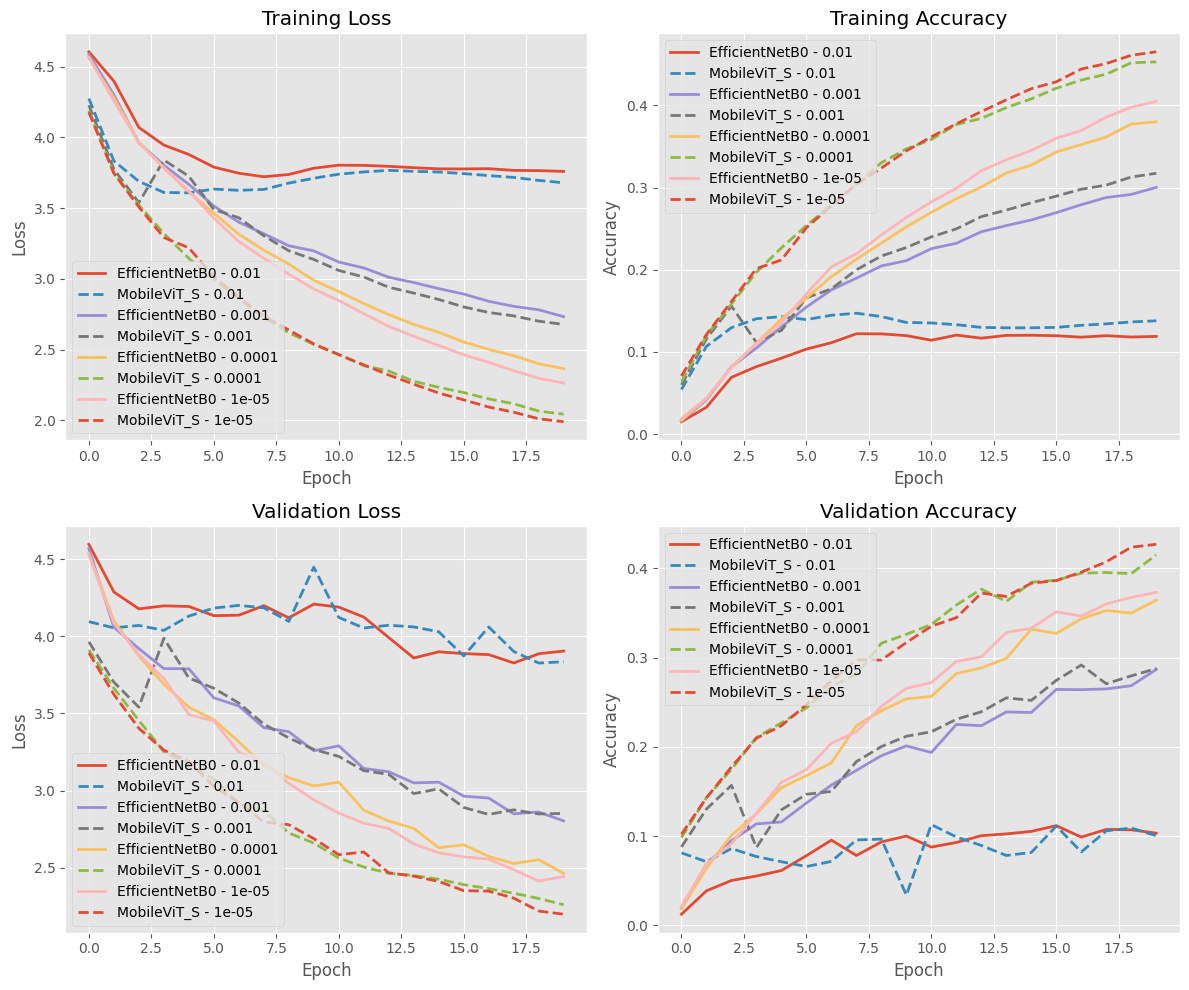

In [13]:
plot_curves_two(all_train_losses_model1, all_train_accuracies_model1, all_val_losses_model1, all_val_accuracies_model1, 
            all_train_losses_model2, all_train_accuracies_model2, all_val_losses_model2, all_val_accuracies_model2, weight_decay_list)

## Try different optimizers

 ======> Training EfficientNetB0_CIFAR100: SGD-512_lr=0.002_weightdecay=1e-05


Overall Progress: 100%|██████████| 20/20 [03:42<00:00, 11.13s/it, train_acc=15.02%, train_loss=3.6043, val_acc=15.08%, val_loss=3.5749]


Training complete!
Training Accuracy: 0.1502, Best Validation Accuracy: 0.1508
 ======> Training EfficientNetB0_CIFAR100: Adagrad-512_lr=0.002_weightdecay=1e-05


Overall Progress: 100%|██████████| 20/20 [03:42<00:00, 11.14s/it, train_acc=12.72%, train_loss=3.7264, val_acc=13.00%, val_loss=3.6964]


Training complete!
Training Accuracy: 0.1272, Best Validation Accuracy: 0.1324
 ======> Training EfficientNetB0_CIFAR100: Adadelta-512_lr=0.002_weightdecay=1e-05


Overall Progress: 100%|██████████| 20/20 [03:44<00:00, 11.23s/it, train_acc=1.44%, train_loss=4.5950, val_acc=1.60%, val_loss=4.5972]


Training complete!
Training Accuracy: 0.0144, Best Validation Accuracy: 0.0160
 ======> Training EfficientNetB0_CIFAR100: Adam-512_lr=0.002_weightdecay=1e-05


Overall Progress: 100%|██████████| 20/20 [03:43<00:00, 11.18s/it, train_acc=40.53%, train_loss=2.2764, val_acc=37.30%, val_loss=2.4013]


Training complete!
Training Accuracy: 0.4053, Best Validation Accuracy: 0.3730
 ======> Training MobileViT_S_CIFAR100: SGD-512_lr0.002_weightdecay-1e-05


Overall Progress: 100%|██████████| 20/20 [04:55<00:00, 14.79s/it, train_acc=11.01%, train_loss=3.8496, val_acc=10.68%, val_loss=3.8637]


Training complete!
Training Accuracy: 0.1101, Best Validation Accuracy: 0.1068
 ======> Training MobileViT_S_CIFAR100: Adagrad-512_lr0.002_weightdecay-1e-05


Overall Progress: 100%|██████████| 20/20 [04:46<00:00, 14.34s/it, train_acc=23.05%, train_loss=3.1315, val_acc=22.16%, val_loss=3.1860]


Training complete!
Training Accuracy: 0.2305, Best Validation Accuracy: 0.2216
 ======> Training MobileViT_S_CIFAR100: Adadelta-512_lr0.002_weightdecay-1e-05


Overall Progress: 100%|██████████| 20/20 [04:47<00:00, 14.38s/it, train_acc=2.39%, train_loss=4.5219, val_acc=2.06%, val_loss=4.5281]


Training complete!
Training Accuracy: 0.0239, Best Validation Accuracy: 0.0226
 ======> Training MobileViT_S_CIFAR100: Adam-512_lr0.002_weightdecay-1e-05


Overall Progress: 100%|██████████| 20/20 [04:47<00:00, 14.38s/it, train_acc=47.16%, train_loss=1.9674, val_acc=42.94%, val_loss=2.1766]


Training complete!
Training Accuracy: 0.4716, Best Validation Accuracy: 0.4294


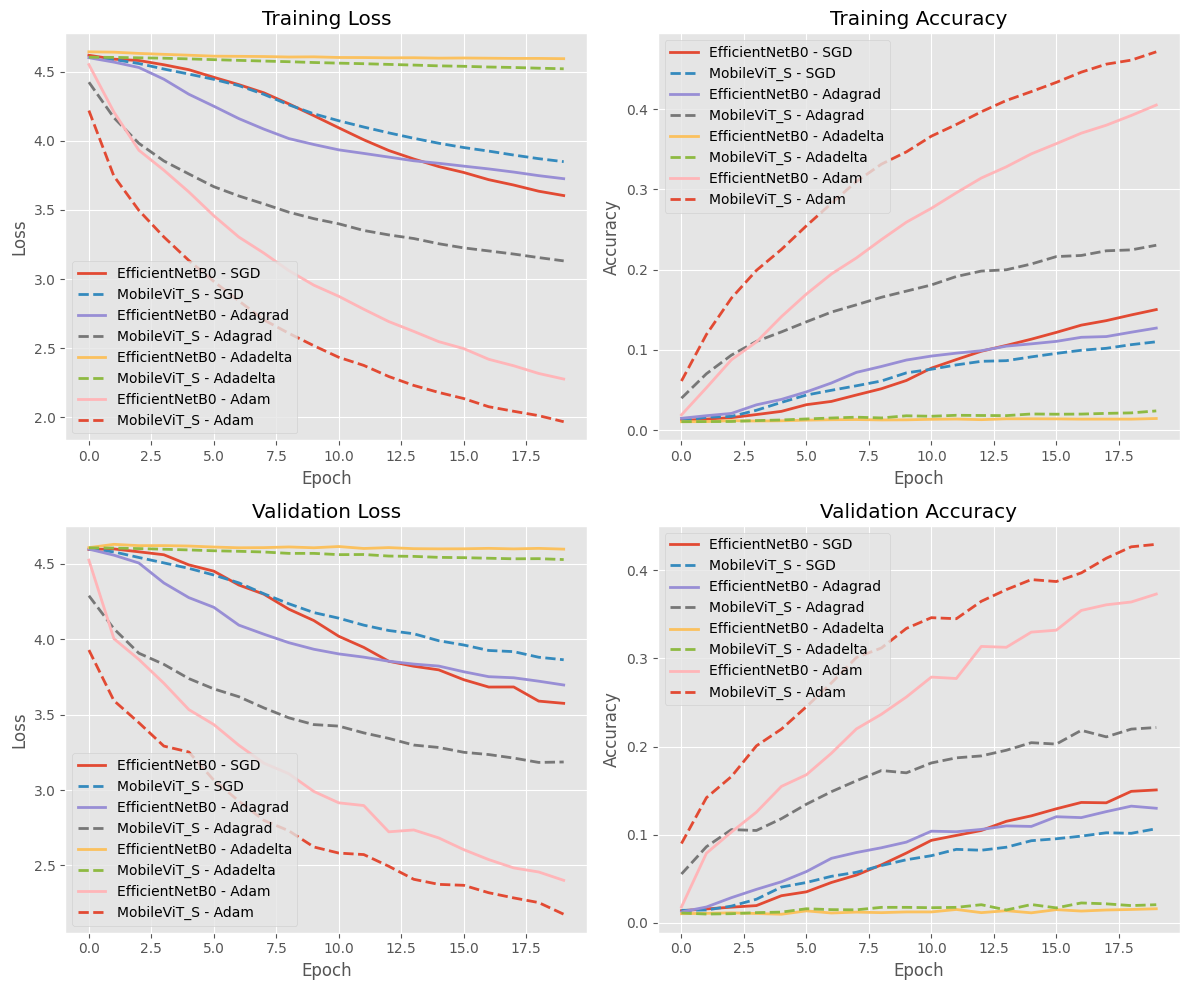

In [16]:
# Training parameters
num_epochs = 20
lr_list = [0.002]
weight_decay_list = [1e-5]
optimizers = [
    'SGD',
    'Adagrad',
    'Adadelta',
    'Adam',
]

all_train_losses_model1 = []
all_train_accuracies_model1 = []
all_val_losses_model1 = []
all_val_accuracies_model1 = []

all_train_losses_model2 = []
all_train_accuracies_model2 = []
all_val_losses_model2 = []
all_val_accuracies_model2 = []

for base_lr in lr_list:
    for weight_decay in weight_decay_list:
        for opt in optimizers:
            # Training for Model 1
            mdl1 = EfficientNetB0_CIFAR100()
            mdl1 = mdl1.to(device)
            if opt == 'SGD':
                optimizer = optim.SGD(mdl1.parameters(), lr=base_lr,
                momentum=0.9, weight_decay=weight_decay)
            elif opt == 'Adagrad':
                optimizer = optim.Adagrad(mdl1.parameters(), lr=base_lr,
                weight_decay=weight_decay)
            elif opt == 'Adadelta':
                optimizer = optim.Adadelta(mdl1.parameters(), lr=base_lr,
                weight_decay=weight_decay)
            elif opt == 'Adam':
                optimizer = optim.Adam(mdl1.parameters(), lr=base_lr,
                weight_decay=weight_decay)
            model_name1 = mdl1.__class__.__name__
            print(f" ======> Training {model_name1}: {opt}-{batch_size}_lr={base_lr}_weightdecay={weight_decay}")
            optimizer1 = optimizer
            scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=200, gamma=0.97)
            log_dir1 = f'./logs/{model_name1}/{opt}-{batch_size}_lr{base_lr}_wd-{weight_decay}_e{num_epochs}'
            train_losses1, train_accuracies1, val_losses1, val_accuracies1 = train_model(mdl1, trainloader_basic, valloader_basic, optimizer1, num_epochs, scheduler=scheduler1, log_dir=log_dir1)
            all_train_losses_model1.append(train_losses1)
            all_train_accuracies_model1.append(train_accuracies1)
            all_val_losses_model1.append(val_losses1)
            all_val_accuracies_model1.append(val_accuracies1)

for base_lr in lr_list:
    for weight_decay in weight_decay_list:
        for opt in optimizers:
            # Training for Model 2
            mdl2 = MobileViT_S_CIFAR100()
            mdl2 = mdl2.to(device)
            if opt == 'SGD':
                optimizer = optim.SGD(mdl2.parameters(), lr=base_lr,
                momentum=0.9, weight_decay=weight_decay)
            elif opt == 'Adagrad':
                optimizer = optim.Adagrad(mdl2.parameters(), lr=base_lr,
                weight_decay=weight_decay)
            elif opt == 'Adadelta':
                optimizer = optim.Adadelta(mdl2.parameters(), lr=base_lr,
                weight_decay=weight_decay)
            elif opt == 'Adam':
                optimizer = optim.Adam(mdl2.parameters(), lr=base_lr,
                weight_decay=weight_decay)
            model_name2 = mdl2.__class__.__name__
            print(f" ======> Training {model_name2}: {opt}-{batch_size}_lr{base_lr}_weightdecay-{weight_decay}")
            optimizer2 = optimizer
            scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=200, gamma=0.97)
            log_dir2 = f'./logs/{model_name2}/{opt}-{batch_size}_lr{base_lr}_wd-{weight_decay}_e{num_epochs}'
            train_losses2, train_accuracies2, val_losses2, val_accuracies2 = train_model(mdl2, trainloader_basic, valloader_basic, optimizer2, num_epochs, scheduler=scheduler2, log_dir=log_dir2)
            all_train_losses_model2.append(train_losses2)
            all_train_accuracies_model2.append(train_accuracies2)
            all_val_losses_model2.append(val_losses2)
            all_val_accuracies_model2.append(val_accuracies2)

plot_curves_two(all_train_losses_model1, all_train_accuracies_model1, all_val_losses_model1, all_val_accuracies_model1, 
            all_train_losses_model2, all_train_accuracies_model2, all_val_losses_model2, all_val_accuracies_model2, optimizers)